### **Data used - RAVDESS database(48kHz) & TESS database(22.5kHz)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install json_tricks

##**Data Preprocessing**

*The audio samples are of different sample length, we have to make all the fles to be in same sample length, so let's find the maximum sample length in the audio samples and pad some audios whose sample length is less*

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Foundational_Projects/Speech_Emotion_Recognition/Data"

In [ ]:
import os
import numpy as np
import librosa
import noisereduce as nr
from pydub import AudioSegment, effects
import tensorflow as tf
import keras
import sklearn
import matplotlib.pyplot as plt
from librosa import display

##**Visualization & preprocessing on a single audio file**

In [ ]:
audio = "/content/drive/MyDrive/Foundational_Projects/Speech_Emotion_Recognition/Data/Happy/OAF_back_happy.wav"

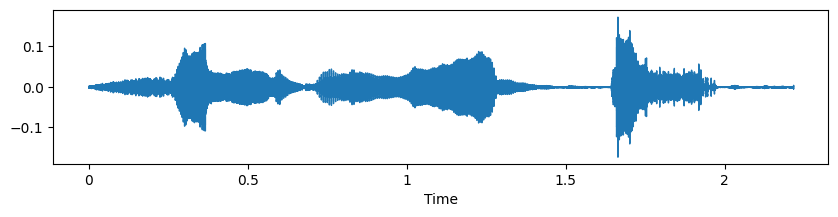

In [ ]:
sound,sr= librosa.load(audio, sr=None) # audio is loaded as a np array
plt.figure(figsize=(10, 2))
librosa.display.waveshow(sound)

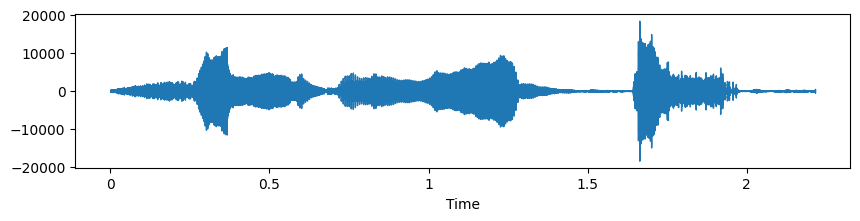

In [ ]:
raw_sound = AudioSegment.from_file(audio)
normalizedsound = effects.normalize(raw_sound, headroom = 5.0) # Normalizing to 5DB (making the loudness to this threshold level)
normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')

plt.figure(figsize=(10,2))
librosa.display.waveshow(normal_x)

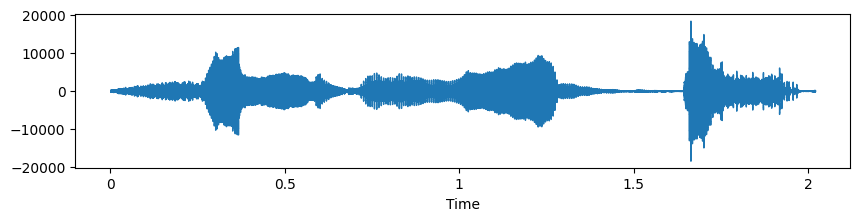

In [ ]:
trim_audio, i = librosa.effects.trim(normal_x, top_db=30)
plt.figure(figsize=(10, 2))
librosa.display.waveshow(trim_audio)

In [ ]:
# Function to find the max sample length
sample_lengths = []
for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            audio, sr = librosa.load(file_path, sr=None)
            sample_lengths.append(len(audio))

print("Maximum Sample length is:",np.max(sample_lengths))

Maximum Sample length is: 145172


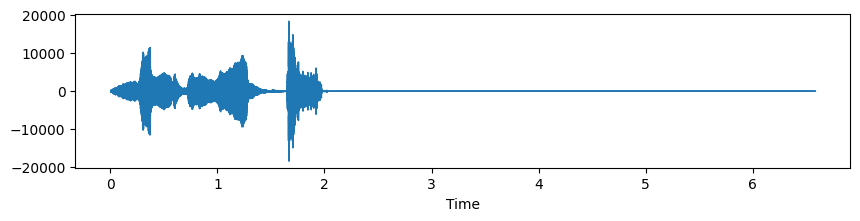

In [ ]:
padded_x = np.pad(trim_audio, (0, 145172-len(trim_audio)), 'constant')
plt.figure(figsize=(10,2))
librosa.display.waveshow(padded_x)

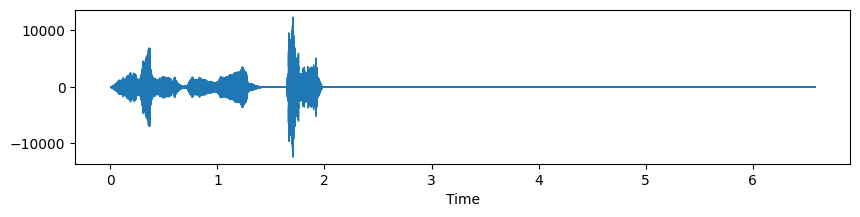

In [ ]:
final_x = nr.reduce_noise(y=padded_x,
                          sr = sr)
plt.figure(figsize=(10,2))
librosa.display.waveshow(final_x)


##**Preprocessing on audio files**


In [ ]:
total_length = 145172 # desired frame length for all of the audio samples.
frame_length = 2048
hop_length = 512

rms,zcr,mfccs= [], [], []
emotions = []

for root, dirs, files in os.walk(DATA_DIR):
  for file in files:
    if file.endswith(".wav"):
      file_path = os.path.join(root, file)

      emotion_label = os.path.basename(root).lower()
      emotions.append(emotion_label)
      audio, sr = librosa.load(file_path, sr=None) # load audio

      raw_sound = AudioSegment.from_file(file_path)

      normalizedsound = effects.normalize(raw_sound, headroom = 5.0) # normalize the audio

      normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')

      trim_audio, i = librosa.effects.trim(normal_x, top_db=30) # trim the audio where silence occurred

      padded_x = np.pad(trim_audio, (0, total_length-len(trim_audio)), 'constant') # pad the audio to maximum length

      final_x = nr.reduce_noise(y=padded_x,
                          sr = sr) # reduce noise if any

      # Features extraction
      f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square

      f2 = librosa.feature.zero_crossing_rate(y=final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR

      f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC

      rms.append(f1)
      zcr.append(f2)
      mfccs.append(f3)

In [ ]:
f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfccs).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

In [ ]:
print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

ZCR shape: (2400, 284, 1)
RMS shape: (2400, 284, 1)
MFCCs shape: (2400, 284, 13)


In [ ]:
# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

from sklearn.preprocessing import LabelEncoder

# Convert string labels (e.g., 'happy', 'sad') to numeric
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(emotions)  # e.g., ['happy', 'sad'] → [0, 1]
print(Y)
Y = np.expand_dims(Y, axis=1)
print(Y)


[5 5 5 ... 0 0 0]
[[5]
 [5]
 [5]
 ...
 [0]
 [0]
 [0]]


In [ ]:
# Check label mapping
for i, label in enumerate(label_encoder.classes_):
    print(f"{label} → {i}")

angry → 0
disgust → 1
fear → 2
happy → 3
neutral → 4
sad → 5


##**Saving the data for later use as well**

In [ ]:
import json

x_data = X.tolist()
x_path = '/content/drive/MyDrive/Foundational_Projects/Speech_Emotion_Recognition/X_datanew.json'
with open(x_path, 'w') as f:
    json.dump(x_data, f)

y_data = Y.tolist()
y_path = '/content/drive/MyDrive/Foundational_Projects/Speech_Emotion_Recognition/Y_datanew.json'
with open(y_path, 'w') as f:
    json.dump(y_data, f)


##**Loading the saved data**

In [ ]:
from json_tricks import dump, load
x_path = '/content/drive/MyDrive/Foundational_Projects/Speech_Emotion_Recognition/X_datanew.json'
X = load(x_path)
X = np.asarray(X, dtype = 'float32')

y_path = '/content/drive/MyDrive/Foundational_Projects/Speech_Emotion_Recognition/Y_datanew.json'
Y = load(y_path)
Y = np.asarray(Y, dtype = 'int8')

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

y_train_class = tf.keras.utils.to_categorical(y_train, 6)
y_val_class = tf.keras.utils.to_categorical(y_val, 6)


##**Model Development**

In [ ]:
from keras.models import Sequential
from keras import layers, optimizers, callbacks

In [ ]:
model = Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape = (X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(6,activation='softmax'))
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 284, 64)        │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,894 (210.52 KB)

 Trainable params: 53,894 (210.52 KB)

 Non-trainable params: 0 (0.00 B)

None


##**Saving weights alone**

In [ ]:
batch_size = 24
checkpoint_path = "/content/drive/MyDrive/Data/best_weights.weights.h5"
mcp_save = callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    save_weights_only=True,  # <== ADD THIS LINE
    monitor='val_categorical_accuracy',
    mode='max'
)

rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy',
                                    factor=0.1, patience=100)
# Compile & train
model.compile(loss='categorical_crossentropy',
                optimizer='RMSProp',
                metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class,
                      epochs=200, batch_size = batch_size,
                      validation_data = (x_val, y_val_class),
                      callbacks = [mcp_save, rlrop])
# Define the best weights to the model.
model.load_weights(checkpoint_path)

Epoch 1/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 31s 295ms/step - categorical_accuracy: 0.1751 - loss: 1.7994 - val_categorical_accuracy: 0.2596 - val_loss: 1.7385 - learning_rate: 0.0010
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 289ms/step - categorical_accuracy: 0.2990 - loss: 1.6158 - val_categorical_accuracy: 0.3173 - val_loss: 1.5632 - learning_rate: 0.0010
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 298ms/step - categorical_accuracy: 0.3351 - loss: 1.5098 - val_categorical_accuracy: 0.3798 - val_loss: 1.3974 - learning_rate: 0.0010
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 297ms/step - categorical_accuracy: 0.4084 - loss: 1.3986 - val_categorical_accuracy: 0.4183 - val_loss: 1.3683 - learning_rate: 0.0010
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 293ms/step - categorical_accuracy: 0.3919 - loss: 1.3659 - val_categorical_accuracy: 0.4375 - val_loss: 1.2896 - learning_rate: 0.0010
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 24s 275ms/step - categorical_accuracy: 0.4254 - loss: 1.3294 - val_cate

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential()
model.add(layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(6, activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


##**Loading the weights into the model**

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='RMSProp',
              metrics=['categorical_accuracy'])

checkpoint_path = "/content/drive/MyDrive/Foundational_Projects/Speech_Emotion_Recognition/best_weights.weights.h5"
model.load_weights(checkpoint_path)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
y_test_class = tf.keras.utils.to_categorical(y_test, 6)

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test_class, verbose=1)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - categorical_accuracy: 0.8871 - loss: 0.2109
Test Loss: 0.2142, Test Accuracy: 0.8913


In [ ]:
# Save complete model
model.save('/content/drive/MyDrive/Foundational_Projects/Speech_Emotion_Recognition/emotion_model.keras')

In [ ]:
np.save('/content/drive/MyDrive/Foundational_Projects/Speech_Emotion_Recognition/label_classes.npy', label_encoder.classes_)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions (replace `model` and `x_test` with your actual model and test data)
y_probs = model.predict(x_test)
y_pred = np.argmax(y_probs, axis=1)  # predicted class indices
y_true = y_test.flatten()            # true class indices

# Load label encoder classes (if not already loaded)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('/content/drive/MyDrive/Foundational_Projects/Speech_Emotion_Recognition/label_classes.npy', allow_pickle=True)

# Classification report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step
              precision    recall  f1-score   support

       angry       0.90      1.00      0.95         9
     disgust       0.88      0.93      0.90        15
        fear       0.72      1.00      0.84        13
       happy       1.00      0.64      0.78        22
     neutral       1.00      0.96      0.98        24
         sad       0.82      1.00      0.90         9

    accuracy                           0.89        92
   macro avg       0.89      0.92      0.89        92
weighted avg       0.91      0.89      0.89        92



##**Function to preprocess the test audio file**

In [ ]:

label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('/content/drive/MyDrive/Foundational_Projects/Speech_Emotion_Recognition/label_classes.npy', allow_pickle=True)

def preprocess_audio(file_path, total_length=145172, frame_length=2048, hop_length=512):
    # Load and normalize
    audio, sr = librosa.load(file_path, sr=None)
    raw_sound = AudioSegment.from_file(file_path)
    normalizedsound = effects.normalize(raw_sound, headroom=5.0)
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype='float32')

    # Trim silence and pad
    trim_audio, _ = librosa.effects.trim(normal_x, top_db=30)
    padded_x = np.pad(trim_audio, (0, max(0, total_length - len(trim_audio))), 'constant')

    # Noise reduction
    final_x = nr.reduce_noise(y=padded_x, sr=sr)

    # Feature extraction
    f_rms = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length).T
    f_zcr = librosa.feature.zero_crossing_rate(y=final_x, frame_length=frame_length, hop_length=hop_length).T
    f_mfccs = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length=hop_length).T

    features = np.concatenate((f_zcr, f_rms, f_mfccs), axis=1)
    return np.expand_dims(features, axis=0).astype('float32')


##**Testing on a audio file**

In [ ]:
# Load the full model
model = load_model('/content/drive/MyDrive/Foundational_Projects/Speech_Emotion_Recognition/emotion_model.keras')  ved that way

# Preprocess the audio
file_path = '/content/YAF_young_happy.wav'  # path to your test .wav
X_test = preprocess_audio(file_path)

# Predict
pred = model.predict(X_test)
predicted_class = np.argmax(pred, axis=1)[0]
predicted_emotion = label_encoder.inverse_transform([predicted_class])[0]

print(f"Predicted Emotion: {predicted_emotion}")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
Predicted Emotion: happy
